In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/텐서플로와 머신러닝으로 시작하는 자연어처리 PyTorch/6. 챗봇

/content/gdrive/My Drive/Colab Notebooks/텐서플로와 머신러닝으로 시작하는 자연어처리 PyTorch/6. 챗봇


In [3]:
!pip install konlpy

In [0]:
import os
import json
import numpy as np
from konlpy.tag import Okt

import torch
from configs import DEFINES
from preprocess import *
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [0]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))

index_inputs = torch.Tensor(index_inputs).long()
index_outputs = torch.Tensor(index_outputs).long()
index_targets = torch.Tensor(index_targets).long()
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [0]:
vocab_size = prepro_configs['vocab_size']
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
end_index = prepro_configs['end_symbol']
start_index = prepro_configs['std_symbol']

## Hyperparameter Setting

In [0]:
BATCH_SIZE = DEFINES['batch_size']
EPOCHS = 20 

In [0]:
MAX_SEQUENCE_LENGTH = 25

## Configuration

In [0]:
class Config(dict):

  __getitem__ = dict.__getitem__
  __setitem__ = dict.__setitem__

config = Config({'d_hidn': 128, 'd_ffn': 512, 'n_head': 4, 'd_head': 64, 'n_layer': 6,
                 'dropout': 0.1, 'layer_norm_epsilon': 1e-12})

## Common Class
### Positional Encoding

In [0]:
input_sample = index_inputs[:10]
output_sample = index_outputs[:10]

In [11]:
print(input_sample.shape, output_sample.shape)

torch.Size([10, 25]) torch.Size([10, 25])


In [12]:
nn_emb = nn.Embedding(vocab_size, config['d_hidn']) # embedding
input_sample_embs = nn_emb(input_sample)
print(input_sample_embs.shape)

torch.Size([10, 25, 128])


In [0]:
def positional_encoding(dim, sentence_length):
  encoded_vec = np.array([pos/np.power(10000, 2*i/dim) for pos in range(sentence_length) for i in range(dim)])
  encoded_vec[::2] = np.sin(encoded_vec[::2])
  encoded_vec[1::2] = np.cos(encoded_vec[1::2])
  return torch.FloatTensor(encoded_vec.reshape(sentence_length, dim))

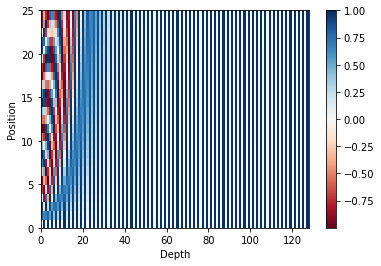

In [14]:
pos_encoding = positional_encoding(config['d_hidn'], MAX_SEQUENCE_LENGTH)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, config['d_hidn']))
plt.ylabel('Position')
plt.colorbar();

In [0]:
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
positions = torch.arange(input_sample.size(1), dtype=input_sample.dtype).expand(input_sample.size(0), input_sample.size(1)).contiguous() + 1

In [16]:
positions

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,

In [17]:
pos_mask = input_sample.eq(0)
positions.masked_fill_(pos_mask, 0) # masking for padded input
pos_embs = nn_pos(positions)

print(pos_embs.shape)

torch.Size([10, 25, 128])


In [18]:
input_sums = input_sample_embs + pos_embs
print(input_sums.shape)

torch.Size([10, 25, 128])


### Attention Pad mask

In [0]:
def get_attn_pad_mask(seq_q, seq_k, i_pad=0):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

### Attention Decoder Mask

In [0]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

Let's define B: batch size, H: d_hidn(128), HD: d_head(64), HN: n_head(4), N: n_layer(6), FD: feedforwarknetwork dimension(512)

## Scaled Dot-Product Attention

In [0]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, config):
    super(ScaledDotProductAttention, self).__init__()
    self.config = config
    self.dropout = nn.Dropout(config['dropout'])
    self.scale = 1 / (config['d_head'] ** 0.5) # scailing

  def forward(self, Q, K, V, attn_mask):
    # Q, K, V: B x HN x T x HD
    scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale) # scores: B x HN x T x T
    scores.masked_fill_(attn_mask, -1e9) 
    attn_prob = nn.Softmax(dim=-1)(scores) 
    attn_prob = self.dropout(attn_prob)
    context = torch.matmul(attn_prob, V) # context: B x HN x T x HD
    return context, attn_prob

## MultiHeadAttention

In [0]:
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super(MultiHeadAttention, self).__init__()
    self.config = config
    self.d_hidn = config['d_hidn']
    self.n_head = config['n_head']
    self.d_head = config['d_head']

    self.W_Q = nn.Linear(self.d_hidn, self.n_head * self.d_head)
    self.W_K = nn.Linear(self.d_hidn, self.n_head * self.d_head)
    self.W_V = nn.Linear(self.d_hidn, self.n_head * self.d_head)
    self.scaled_dot_attn = ScaledDotProductAttention(self.config)
    self.fc = nn.Linear(self.n_head * self.d_head, self.d_hidn)
    self.dropout = nn.Dropout(config['dropout'])

  def forward(self, Q, K, V, attn_mask):
    # Q, K, V : B x T x H
    batch_size = Q.size(0)
    q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2) # q_s: B x HN x T x HD
    k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2) # k_s: B x HN x T x HD
    v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2) # v_s: B x HN x T x HD
    
    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1) # attn_mask: B x HN x T x T
    context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
    # context: B x HN x T x HD, attn_prob: B x HN x T x T
    context = context.transpose(1, 2).reshape(batch_size, -1, self.n_head * self.d_head) # context: B x T x HN x HD --> B x T x (HN * HD)
    output = self.fc(context) # output: B x T x H
    output = self.dropout(output)

    return output, attn_prob

## FeedForwardNetwork

In [0]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, config):
    super(FeedForwardNetwork, self).__init__()
    self.d_hidn = config['d_hidn']
    self.d_ffn = config['d_ffn']
    self.linear1 = nn.Linear(self.d_hidn, self.d_ffn)
    self.linear2 = nn.Linear(self.d_ffn, self.d_hidn)
    self.dropout = nn.Dropout(config['dropout'])

  def forward(self, x):
    # x: B x T x H
    output = F.relu(self.linear1(x)) # output: B x T x FD
    output = self.linear2(output) # output: B x T x H
    output = self.dropout(output)
    return output 

## Encoder
### EncoderLayer

In [0]:
class EncoderLayer(nn.Module):
  def __init__(self, config):
    super(EncoderLayer, self).__init__()
    self.config = config
    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
    self.ffn = FeedForwardNetwork(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])

  def forward(self, input, attn_mask):
    attn_output, attn_prob = self.self_attn(input, input, input, attn_mask)
    attn_output = self.layer_norm1(input + attn_output) # Residual Connection
    ffn_output = self.ffn(attn_output)
    ffn_output = self.layer_norm2(ffn_output + attn_output)
    # ffn_output: B x T x H, attn_prob: B x HN x T x T
    return ffn_output, attn_prob

###  EncoderModule

In [0]:
class Encoder(nn.Module):
  def __init__(self, config):
    super(Encoder, self).__init__()
    self.config = config
    self.enc_emb = nn.Embedding(vocab_size, self.config['d_hidn'], padding_idx=0)
    pos_encoding = positional_encoding(config['d_hidn'], MAX_SEQUENCE_LENGTH)
    self.pos_emb = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
    self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config['n_layer'])])

  def forward(self, input):
    # input: B x T
    positions = torch.arange(input.size(1), device=input.device, dtype=input.dtype).expand(input.size(0), input.size(1)).contiguous() + 1
    pos_mask = input.eq(0)
    positions.masked_fill_(pos_mask, 0)
    output = self.enc_emb(input) + self.pos_emb(positions) # output: B x T x H
    attn_mask = get_attn_pad_mask(input, input)
    attn_probs = []

    for layer in self.layers:
      output, attn_prob = layer(output, attn_mask) # output: B x T x H, attn_prob: B x HN x T x T
      attn_probs.append(attn_prob)

    return output, attn_probs

### Encoder Testing

In [26]:
(Encoder(config)(input_sample)[0]).size()

torch.Size([10, 25, 128])

## Decoder
### DecoderLayer

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super(DecoderLayer, self).__init__()
        self.config = config
        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
        self.ffn = FeedForwardNetwork(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
    
    def forward(self, dec_input, enc_output, self_attn_mask, dec_enc_attn_mask):
        self_att_output, self_attn_prob = self.self_attn(dec_input, dec_input, dec_input, self_attn_mask)
        self_att_output = self.layer_norm1(dec_input + self_att_output)
        dec_enc_att_output, dec_enc_attn_prob = self.dec_enc_attn(self_att_output, enc_output, enc_output, dec_enc_attn_mask)
        dec_enc_att_output = self.layer_norm2(self_att_output + dec_enc_att_output)
        ffn_output = self.ffn(dec_enc_att_output)
        ffn_output = self.layer_norm3(dec_enc_att_output + ffn_output)
        return ffn_output, self_attn_prob, dec_enc_attn_prob

In [0]:
class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        self.config = config
        self.dec_emb = nn.Embedding(vocab_size, self.config['d_hidn'], padding_idx=0)
        pos_encoding = positional_encoding(config['d_hidn'], MAX_SEQUENCE_LENGTH)
        self.pos_emb = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config['n_layer'])])
    
    def forward(self, dec_input, enc_input, enc_output):
        # dec_input: B x T, enc_input: B x T, enc_output: B x T x H
        positions = torch.arange(dec_input.size(1), device=dec_input.device, dtype=dec_input.dtype).expand(dec_input.size(0), 
                                                                                                           dec_input.size(1)).contiguous() + 1
        pos_mask = dec_input.eq(0)
        positions.masked_fill_(pos_mask, 0)
    
        # B x T x H
        dec_output = self.dec_emb(dec_input) + self.pos_emb(positions)

        dec_attn_pad_mask = get_attn_pad_mask(dec_input, dec_input)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_input)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        dec_enc_attn_mask = get_attn_pad_mask(dec_input, enc_input)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
          #  B x T x H, B x HN x T x T, B x HN x T x T
          dec_output, self_attn_prob, dec_enc_attn_prob = layer(dec_output, enc_output, dec_self_attn_mask, dec_enc_attn_mask)
          self_attn_probs.append(self_attn_prob)
          dec_enc_attn_probs.append(dec_enc_attn_prob)

        return dec_output, self_attn_prob, dec_enc_attn_prob

## Transformer

In [0]:
class Transformer(nn.Module):
    def __init__(self, config):
        super(Transformer, self).__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
        self.fc = nn.Linear(self.config['d_hidn'], vocab_size)
    
    def forward(self, enc_input, dec_input):
        # B x T x H, [(B x HN x T x T)]
        enc_output, enc_self_attn_probs = self.encoder(enc_input)
        # B x T x H, [(B x HN x T x T)], [(B x HN x T x T)]
        dec_output, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_input, enc_input, enc_output)
        return F.softmax(self.fc(dec_output), dim=-1), enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

In [40]:
print([*map(lambda x: x[0].shape if isinstance(x, list) else x.shape, Transformer(config)(input_sample, output_sample))])

[torch.Size([10, 25, 20705]), torch.Size([10, 4, 25, 25]), torch.Size([10, 4, 25, 25]), torch.Size([10, 4, 25, 25])]


## Train

In [0]:
class TrainData(Dataset):
  def __init__(self):
    self.inp = index_inputs
    self.out = index_outputs
    self.tar = index_targets

  def __getitem__(self, s):
    return self.inp[s], self.out[s], self.tar[s]

  def __len__(self):
    return self.tar.shape[0]

train_data = TrainData()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [0]:
model = Transformer(config)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.0001)

In [0]:
def train(train_loader=train_loader, model=model, optimizer=optimizer, num_epochs=2*EPOCHS):
  model.train()
  losses = []

  for epoch in range(1, num_epochs):
    for idx, (inp, out, target) in enumerate(train_loader):
      inp, out, target = inp.to(device), out.to(device), target.to(device)

      output = model(inp, out)[0]

      logit = torch.empty_like(out, dtype=torch.float32)

      for i in range(inp.size(0)):
        logit[i] = (output[i][:, out[i]]).diag()

      loss = -torch.log(logit.view(-1, 1).squeeze()).sum()
      loss_val = loss.item() / (inp.size(0)*MAX_SEQUENCE_LENGTH)
      losses.append(loss_val)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch == 1 or epoch % 5 == 0:
      print(f"Epoch: {epoch}, Train Loss: {loss_val}")

  return losses

In [78]:
losses = train()

Epoch: 1, Train Loss: 2.0883338928222654
Epoch: 5, Train Loss: 0.8819380187988282
Epoch: 10, Train Loss: 0.5392506790161132
Epoch: 15, Train Loss: 0.3794776153564453
Epoch: 20, Train Loss: 0.27690345764160157
Epoch: 25, Train Loss: 0.18654647827148438
Epoch: 30, Train Loss: 0.12426425933837891
Epoch: 35, Train Loss: 0.03505969285964966
